##### Librerías

In [38]:
import pandas as pd
import numpy as np
import geopandas as gp
from shapely.geometry import Point
import requests
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## Datos Censo OIM - 2019
Lectura de fuente de datos desde el servidor ODKCentral.  Se lee el json de cada una de las entidades y se guarda en un CSV eliminando las columnas que no se requieren, definiendo índices y tipos de datos como fechas, flotantes o enteros, renombrando las columnas para que sean más sencillas de entender y manejar.

In [3]:
## CREAR DATAFRAMES

# Dataframe de VIVIENDAS
url_test = 'https://odkcentral.naritas.co/v1/projects/2/forms/build_Censo-Orika-OIM_v3.svc/Submissions'
r = requests.get(url_test, auth=('hyances@gmail.com', 'h9mb3rt0'))
r_json = r.json().get('value')
df_viviendas = pd.read_json(json.dumps(r_json), orient='records')
df_viviendas.to_json(path_or_buf='viviendas.json', orient='records', date_format='iso')

# crear campos de latitud y longitud
longitud = []
latitud = []
for point in df_viviendas['ubicacion-vivienda']:
    longitud.append(point.get('coordinates')[0])
    latitud.append(point.get('coordinates')[1])
df_viviendas['longitud'] = longitud
df_viviendas['latitud'] = latitud

# Corregir posición y referencia Isleta
df_viviendas.loc[39, 'longitud'] = -75.75213
df_viviendas.loc[39, 'latitud'] = 10.17567
df_viviendas.loc[38, 'ref-vivienda'] = 'Andri'

# Crear campo de encuestadoras
encuestadora = []
for envio in df_viviendas['__system']:
    encuestadora.append(envio.get('submitterName'))
df_viviendas['encuestadora'] = encuestadora

# Dataframe de HOGARES
url_test = 'https://odkcentral.naritas.co/v1/projects/2/forms/build_Censo-Orika-OIM_v3.svc/Submissions.HOGARES'
r = requests.get(url_test, auth=('hyances@gmail.com', 'h9mb3rt0'))
r_json = r.json().get('value')
df_hogares = pd.read_json(json.dumps(r_json), orient='records')
df_hogares.to_json(path_or_buf='hogares.json', orient='records', date_format='iso')

# Dataframe de PERSONAS
url_test = 'https://odkcentral.naritas.co/v1/projects/2/forms/build_Censo-Orika-OIM_v3.svc/Submissions.HOGARES.PERSONAS'
r = requests.get(url_test, auth=('hyances@gmail.com', 'h9mb3rt0'))
r_json = r.json().get('value')
df_personas = pd.read_json(json.dumps(r_json), orient='records')
df_personas.to_json(path_or_buf='personas.json', orient='records', date_format='iso')

# Eliminar duplicados
df_viviendas.drop(df_viviendas[df_viviendas['__id']=='uuid:61e0a91a-718d-4a74-912f-1d51cbffcf7a'].index,
                  axis=0, inplace=True)

df_hogares.drop(df_hogares[df_hogares['__Submissions-id']=='uuid:61e0a91a-718d-4a74-912f-1d51cbffcf7a'].index,
                  axis=0, inplace=True)

df_personas.drop(df_personas[df_personas['__Submissions-HOGARES-id']=='bf384ec25b75112a3524947299e6837acbcd6814'].index,
                  axis=0, inplace=True)
'''
# df_viviendas.duplicated(['longitud','latitud'])
# df_viviendas.drop_duplicates(subset='', keep='first', inplace=True)
'''

# Calcular edad de las viviendas
df_viviendas['edad_construccion'] = (pd.to_datetime(pd.Series([pd.to_datetime('today').date()] * (len(df_viviendas) + 1) )) - pd.to_datetime(df_viviendas['ano-construccion'])) / np.timedelta64(1, 'Y')
df_viviendas['edad_construccion'] = df_viviendas['edad_construccion'].fillna(0).astype(int)

# Total de habitantes por viviendas
df_viviendas['habitantes_vivienda'] = df_viviendas['__id'].map(df_hogares.groupby(['__Submissions-id'])['numero-personas'].sum())

## Geocoder viviendas por sector
# Crear dataframes de sectores
sectores = gp.read_file('../../../../Documentos/PERSONAL/Fundación "Data for Change"/Concejo Comunitario Isla Grande/Censo Orika/Censo OIM/Censo Orika - Productos/Archivos geográficos/Sectores/sectores-orika.shp')
# Crear dataframes de puntos
df_viviendas['coordenada'] = gp.points_from_xy(df_viviendas.longitud, df_viviendas.latitud)
sector = []
for coordenada in df_viviendas['coordenada']:
    filter = sectores.geometry.contains(coordenada)
    sector.append(sectores.loc[filter]['name'].to_list())
df_viviendas['sector'] = sector
df_viviendas['sector'] = df_viviendas['sector'].str.get(0)
df_viviendas['sector'].fillna('SIN-SECTOR')

# Crear dataframes de sectores
titulacion = gp.read_file('/home/humberto/Documentos/PERSONAL/Fundación "Data for Change"/Concejo Comunitario Isla Grande/Titulación Colectiva/Globos/Globos.shp')
titulo = []
for coordenada in df_viviendas['coordenada']:
    filter = titulacion.geometry.contains(coordenada)
    titulo.append(titulacion.loc[filter]['name'].to_list())
df_viviendas['titulo'] = titulo
df_viviendas['titulo'] = df_viviendas['titulo'].str.get(0)
df_viviendas['titulo'].fillna('FUERA-TITULO')


# Calcular edad de las personas
df_personas['edad'] = (pd.to_datetime(pd.Series([pd.to_datetime('today').date()] * (len(df_personas) + 1) )) - pd.to_datetime(df_personas['nacimiento'])) / np.timedelta64(1, 'Y')
df_personas['edad'] = df_personas['edad'].fillna(0).astype(int)

# Agregar columnas de ocupación
df_personas[['ocupacion1', 'ocupacion2', 'ocupacion3', 'ocupacion4', 'ocupacion5']] = df_personas['ocupacion'].str.split(' ', expand=True)


# Eliminar campos innecesarios
df_viviendas = df_viviendas.drop(['coordenada','HOGARES_count', '__system', 'deviceid', 'end', 'meta', 'start', 'ubicacion-vivienda'], axis=1)
df_hogares = df_hogares.drop(['PERSONAS_count'], axis=1)

#Organizar los campos en todos los datasets


# Dataframe de TABLA unificada
tabla = pd.merge(df_viviendas, df_hogares, how='inner', left_on='__id', right_on='__Submissions-id', validate='1:m')
tabla = pd.merge(tabla, df_personas, how='inner', left_on='__id_y', right_on='__Submissions-HOGARES-id', validate='1:m')

# Crear archivos CSV
df_viviendas.to_csv('../../../../Documentos/PERSONAL/Fundación "Data for Change"/Concejo Comunitario Isla Grande/Censo Orika/Censo OIM/Resultados/VIVIENDAS.csv',
                    header=['__id', 'anoconstruccion', 'firma', 'numerohogares',
       'numerovivienda', 'refvivienda', 'tipotenencia',
       'tipotenencia_otro', 'today', 'longitud', 'latitud', 'encuestadora',
       'edadconstruccion', 'habitantes', 'sector', 'titulo'], index=False)
df_hogares.to_csv('../../../../Documentos/PERSONAL/Fundación "Data for Change"/Concejo Comunitario Isla Grande/Censo Orika/Censo OIM/Resultados/HOGARES.csv', index=False)
df_personas.to_csv('../../../../Documentos/PERSONAL/Fundación "Data for Change"/Concejo Comunitario Isla Grande/Censo Orika/Censo OIM/Resultados/PERSONAS.csv', index=False)
tabla.to_csv('../../../../Documentos/PERSONAL/Fundación "Data for Change"/Concejo Comunitario Isla Grande/Censo Orika/Censo OIM/Resultados/TABLA.csv', index=False)

### Censo Covid-19
La comunidad requiere el archivo del censo con la reorganización de las columnas para que sea más sencillo la gestión de entrega de ayudas humanitarias.  _8 de abril de 2020._

In [13]:
'''
# Orden deseado de las columnas:

[sector, numero vivienda, referencia vivienda/ tipo tenencia/ # hogares/  # personas/ 
nombre/ apellidos/ año residencia hogar/ procedencia/ autoidentificacion/ año nacimiento/ 
edad/ parentesco/ ocupación/ nivel educativo/ saberes ancestrales/ 
ubicacion y encuestadora]

'''

df_covid = pd.read_csv('../../../../Documentos/PERSONAL/Fundación "Data for Change"\
                      /Concejo Comunitario Isla Grande/Censo Orika/Censo OIM/Resultados/TABLA.csv')
df_covid = df_covid[['sector', 'numero-vivienda', 'ref-vivienda', 'tipo-tenencia', 'numero-hogares', 'numero-personas',
        'nombres', 'apellidos', 'ano-residencia-hogar', 'procedencia-hogar', 'autoidentificacion',
        'nacimiento', 'edad', 'parentesco', 'ocupacion', 'nivel-educativo', 'saberes-ancentrales',
        'longitud', 'latitud', 'encuestadora']]
df_covid['edad'] = (pd.to_datetime(pd.Series([pd.to_datetime('today').date()] * (len(df_covid) + 1) )) - pd.to_datetime(df_covid['nacimiento'])) / np.timedelta64(1, 'Y')
df_covid['edad'] = df_covid['edad'].fillna(0).astype(int)
df_covid.to_csv('../../../../Documentos/PERSONAL/Fundación "Data for Change"/Concejo Comunitario Isla Grande/Censo Orika/Censo OIM/Resultados/COVID19-2020-04-08.csv', index=False)


In [77]:
df_personas = pd.read_csv('../../../../Documentos/PERSONAL/Fundación "Data for Change"/Concejo Comunitario Isla Grande/Censo Orika/Censo OIM/Resultados/COVID19-2020-04-08.csv')

### Actualización Censo 2021 - Coosalud (EPS)
La comunidad requiere procesar los datos de la actualización del censo hecha por la EPS Coosalud.  _12 de agosto de 2021._

In [65]:
#parser = lambda date: dt.datetime.strptime(date, '%m/%d/%Y')
# , parse_dates=[2, 16], date_parser=parser
# /Formato Censo Actualizado Islas del  Rosario.csv',\

df_personas = pd.read_csv('../../../../Documentos/PERSONAL/Fundación "Data for Change"\
/Concejo Comunitario Isla Grande/Censo Orika/Censo Cosalud 2021\
/censoactualizado.csv',\
                           dtype={'edad': np.float64}, verbose=True, decimal=',')

Tokenization took: 1.46 ms
Type conversion took: 3.21 ms
Parser memory cleanup took: 0.00 ms


In [78]:
df_personas.head()

,sector,numero-vivienda,ref-vivienda,tipo-tenencia,numero-hogares,numero-personas,nombres,apellidos,ano-residencia-hogar,procedencia-hogar,autoidentificacion,nacimiento,edad,parentesco,ocupacion,nivel-educativo,saberes-ancentrales,longitud,latitud,encuestadora
0,NaN,503,punta motena,trabajo,1,6,yimi Alfredo,torres julio,1998-01-01,isla-grande,afrocolombiano-a-,1981-01-12,39,jefe-a-delhogar,celador,secundaria-completa,pesca gallero musica baile Cocina-tradicional,-75.755447,10.176612,yuris_brons
1,NaN,503,punta motena,trabajo,1,6,yuris,Brons Medrano,1998-01-01,isla-grande,afrocolombiano-a-,1975-08-14,44,companero-a-,serviciosturisticos laboresdelhogar,secundaria-completa,baile musica Cocina-tradicional,-75.755447,10.176612,yuris_brons
2,NaN,503,punta motena,trabajo,1,6,Sebastián,Molina Brawm,1998-01-01,isla-grande,afrocolombiano-a-,1994-04-25,25,hijo-a-,serviciosturisticos,tecnico-incompleto,pesca baile musica,-75.755447,10.176612,yuris_brons
3,NaN,503,punta motena,trabajo,1,6,yimi,torres Brons,1998-01-01,isla-grande,afrocolombiano-a-,1999-08-26,20,hijo-a-,estudiante,secundaria-incompleta,pesca gallero baile musica Cocina-tradicional,-75.755447,10.176612,yuris_brons
4,NaN,503,punta motena,trabajo,1,6,Angela yimara,Torres Brons,1998-01-01,isla-grande,afrocolombiano-a-,2001-10-22,18,hijo-a-,estudiante,tecnico-incompleto,pesca baile musica Cocina-tradicional gallero,-75.755447,10.176612,yuris_brons


In [79]:
df_personas.columns

Index(['sector', 'numero-vivienda', 'ref-vivienda', 'tipo-tenencia',
       'numero-hogares', 'numero-personas', 'nombres', 'apellidos',
       'ano-residencia-hogar', 'procedencia-hogar', 'autoidentificacion',
       'nacimiento', 'edad', 'parentesco', 'ocupacion', 'nivel-educativo',
       'saberes-ancentrales', 'longitud', 'latitud', 'encuestadora'],
      dtype='object')

In [80]:
df_personas.dtypes

sector                   object
numero-vivienda           int64
ref-vivienda             object
tipo-tenencia            object
numero-hogares            int64
numero-personas           int64
nombres                  object
apellidos                object
ano-residencia-hogar     object
procedencia-hogar        object
autoidentificacion       object
nacimiento               object
edad                      int64
parentesco               object
ocupacion                object
nivel-educativo          object
saberes-ancentrales      object
longitud                float64
latitud                 float64
encuestadora             object
dtype: object

In [81]:
df_personas.sector.unique()

array([nan, 'Yazmin', 'El Mocho', 'Isleta', 'El Silencio', 'Guinda Mono',
       'Petares', 'Sector La Punta'], dtype=object)

In [62]:
#df_personas['edad_calculada'] = (pd.to_datetime(pd.Series([pd.to_datetime('today').date()] * (len(df_personas) + 1) )) - pd.to_datetime(df_personas['edad'])) / np.timedelta64(1, 'Y')
#df_personas['edad_calculada'] = df_personas['edad_calculada'].fillna(0).astype(int)

In [70]:
# Grupos Etarios
# Se sigue la definición descrita en:
# https://www.culturarecreacionydeporte.gov.co/es/areas-de-trabajo/practicas-culturales/grupos-etarios

df_personas['grupos_etarios'] = pd.cut(df_personas.edad, bins=[0, 14, 26, 59, 100], labels=['Niños (0-14)', 'Jóvenes (15-26)', 'Adultos (27-59)', 'Mayores (+60)'])

grupo_m = df_personas[df_personas['sexo']=='Masculino'].groupby(['grupos_etarios'])['grupos_etarios'].count().to_frame()
grupo_m['sexo'] = ['Masculino'] * len(grupo_m)
grupo_f = df_personas[df_personas['sexo']=='Femenino'].groupby(['grupos_etarios'])['grupos_etarios'].count().to_frame()
grupo_f['sexo'] = ['Femenino'] * len(grupo_f)
piramide = pd.concat([grupo_m, grupo_f])
piramide.loc[piramide.sexo != 'Femenino', 'grupos_etarios'] *= -1
piramide['grupos'] = piramide.index
piramide.columns = ['total', 'sexo', 'grupo']
piramide.reset_index(drop=True, inplace=True)
piramide


,total,sexo,grupo
0,0,Masculino,Niños (0-14)
1,0,Masculino,Jóvenes (15-26)
2,0,Masculino,Adultos (27-59)
3,0,Masculino,Mayores (+60)
4,0,Femenino,Niños (0-14)
5,0,Femenino,Jóvenes (15-26)
6,0,Femenino,Adultos (27-59)
7,0,Femenino,Mayores (+60)


In [72]:
df_personas['grupos_etarios'] = pd.cut(df_personas.edad, bins=[0, 14, 26, 59, 100], labels=['Niños', 'Jóvenes', 'Adultos', 'Mayores'])
df_personas['grupos_etarios']
df_personas.groupby(['grupos_etarios', 'autoidentificacion'])['grupos_etarios'].count() 

KeyError: 'autoidentificacion'

In [72]:
df_personas['grupos_etarios'] = pd.cut(df_personas.edad, bins=[0, 14, 26, 59, 100], labels=['Niños', 'Jóvenes', 'Adultos', 'Mayores'])
df_personas['grupos_etarios']
df_personas.groupby(['grupos_etarios', 'nivel-educativo'])['grupos_etarios'].count() 

grupos_etarios  nivel-educativo         
Niños           ninguno                      66
                primaria-completa             3
                primaria-incompleta         120
                secundaria-completa           2
                secundaria-incompleta        63
Jóvenes         ninguno                       2
                postgrado                     3
                primaria-completa            10
                primaria-incompleta          10
                secundaria-completa          54
                secundaria-incompleta        99
                tecnico-completo             13
                tecnico-incompleto           13
                tecnologo-completo            6
                tecnologo-incompleto          4
                universitario-completo        7
                universitario-incompleto     11
Adultos         ninguno                      13
                postgrado                     4
                primaria-completa            44

In [73]:
df_personas['grupos_etarios'] = pd.cut(df_personas.edad, bins=[0, 14, 26, 59, 100], labels=['Niños', 'Jóvenes', 'Adultos', 'Mayores'])
df_personas['grupos_etarios']
df_personas.groupby(['grupos_etarios', 'lugar-nacimiento'])['grupos_etarios'].count()

KeyError: 'lugar-nacimiento'

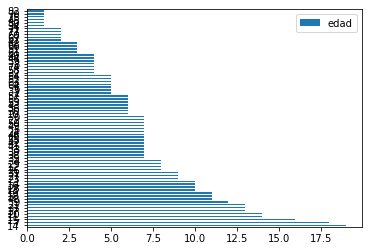

In [115]:
edad = df_personas.edad[df_personas['sexo']== 'Masculino'].value_counts().to_frame()
edad.plot.barh()

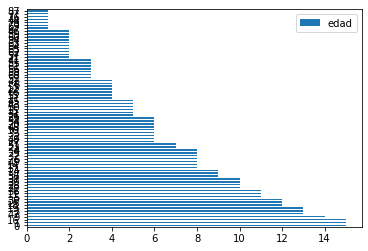

In [116]:
edad = df_personas.edad[df_personas['sexo']== 'Femenino'].value_counts().to_frame()
edad.plot.barh()

### Análisis de datos
Analizar los datos poblacionales usando los tres _Dataframes_ creados con las fuentes _Json_.

In [6]:
print('Viviendas: ' + str(len(df_viviendas)))
print('Hogares: ' + str(len(df_hogares)))
print('Personas: ' + str(len(df_personas)))

Viviendas: 239
Hogares: 291
Personas: 966


In [7]:
viviendas_encuestadora = df_viviendas.groupby(['encuestadora'])['encuestadora'].count()
personas_encuestadora = tabla.groupby(['encuestadora'])['encuestadora'].count()
resultados_encuestadoras = pd.concat([viviendas_encuestadora, personas_encuestadora], axis=1)
resultados_encuestadoras.columns = ['viviendas', 'personas']
#resultados_encuestadoras['pers-viv'] = resultados_encuestadoras['personas']/resultados_encuestadoras['viviendas']
resultados_encuestadoras

,viviendas,personas
encuestadora,,
isabel_camargo,71,318
katherine_villareal,29,91
yolandita_moreno,44,207
yuleidis_villalobo,60,241
yuris_brons,35,109


In [8]:
dias = pd.to_datetime('today') - pd.to_datetime(df_viviendas['today'].min())
print('Días de encuesta: ' + str(dias.days))
print('Viviendas por día: ' + str(len(df_viviendas)/dias.days))
print('Viviendas día por encuestadora: ' + str((len(df_viviendas)/dias.days)/len(resultados_encuestadoras)))

Días de encuesta: 69
Viviendas por día: 3.463768115942029
Viviendas día por encuestadora: 0.6927536231884057


In [9]:
df_viviendas.groupby(['encuestadora'])['today'].max()

encuestadora
isabel_camargo         2019-05-16
katherine_villareal    2019-05-07
yolandita_moreno       2019-05-20
yuleidis_villalobo     2019-05-23
yuris_brons            2021-09-03
Name: today, dtype: object

#### Viviendas censadas

In [13]:
a_censar = pd.read_csv('Censo Orika/Censo OIM/sectores a censar/viviendas-a-censar.csv')
censadas = pd.read_csv('Censo Orika/Censo OIM/sectores a censar/viviendas-censadas.csv')
restantes = a_censar['NUMPOINTS'] - censadas['NUMPOINTS']
sectores = a_censar['name']
viviendas_restantes = pd.concat([sectores, a_censar['NUMPOINTS'], censadas['NUMPOINTS'], restantes], axis=1)
viviendas_restantes.columns=['Sector', 'A censar', 'Censadas', 'Restantes']
viviendas_restantes

,Sector,A censar,Censadas,Restantes
0,El Mocho,95,63,32
1,Sector La Punta,49,30,19
2,Guinda Mono,69,17,52
3,Yazmin,39,37,2
4,Isleta,13,4,9
5,Petares,47,15,32
6,El Silencio,3,8,-5


In [14]:
print('Viviendas censadas dentro de los sectores: ' + str(censadas['NUMPOINTS'].sum()))
print('Viviendas censadas fuera de los sectores: ' + str(218 - censadas['NUMPOINTS'].sum()))

Viviendas censadas dentro de los sectores: 174
Viviendas censadas fuera de los sectores: 44


In [66]:
print('Promedio de habitantes por vivienda: ' + str(df_viviendas['habitantes_vivienda'].mean()))
print('Maximo de habitantes por vivienda: ' + str(df_viviendas['habitantes_vivienda'].max()))
print('Mínimo de habitantes por vivienda: ' + str(df_viviendas['habitantes_vivienda'].min()))
print('Moda de habitantes por vivienda: ' + str(df_viviendas['habitantes_vivienda'].mode()))
print('Counts de habitantes por vivienda: ' + str(df_viviendas['habitantes_vivienda'].value_counts()))

Promedio de habitantes por vivienda: 4.01673640167364
Maximo de habitantes por vivienda: 18
Mínimo de habitantes por vivienda: 1
Moda de habitantes por vivienda: 0    3
dtype: int64
Counts de habitantes por vivienda: 3     49
4     48
5     36
2     34
1     26
6     16
8     14
7      9
9      4
18     1
12     1
10     1
Name: habitantes_vivienda, dtype: int64


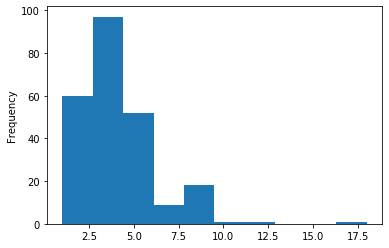

In [69]:
df_viviendas['habitantes_vivienda'].plot.hist()

In [9]:
df_viviendas.groupby(['tipo-tenencia'])['tipo-tenencia'].count()

tipo-tenencia
arriendo     21
familiar     11
otro          3
propia      144
trabajo      60
Name: tipo-tenencia, dtype: int64

In [11]:
df_viviendas.groupby(['tipo-tenencia_otro'])['tipo-tenencia_otro'].count()

tipo-tenencia_otro
Acentral             1
Vivienda prestada    1
prestada             1
Name: tipo-tenencia_otro, dtype: int64

In [10]:
print('Edad promedio de las vivendas: ' + str(df_viviendas['edad_construccion'].mean()) + ' años.')

Edad promedio de las vivendas: 16.812455918909606 años.


In [13]:
df_personas.columns

Index(['__Submissions-HOGARES-id', '__id', 'ano-residencia-persona',
       'apellidos', 'autoidentificacion', 'autoidentificacion_otra',
       'lugar-nacimiento', 'lugar-nacimiento_otro', 'nacimiento',
       'nivel-educativo', 'nombre-madre', 'nombre-padre', 'nombres',
       'ocupacion', 'ocupacion_otra', 'parentesco', 'parentesco_otro',
       'saberes-ancentrales', 'saberes-ancentrales_otro', 'sexo'],
      dtype='object')

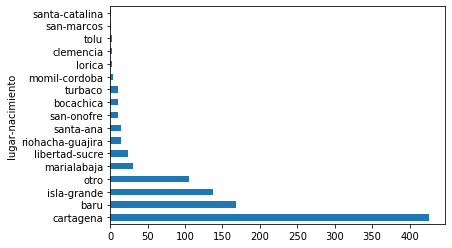

In [45]:
df_personas.groupby(['lugar-nacimiento'])['lugar-nacimiento'].count().sort_values(ascending=False).plot.barh()

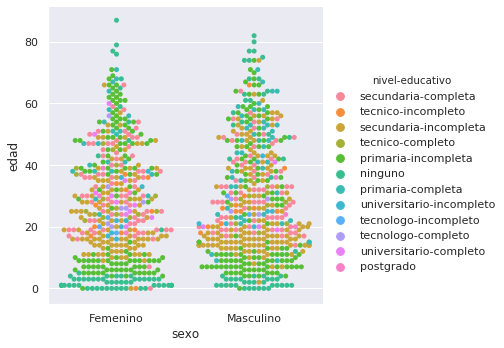

In [76]:
sns.catplot(x='sexo', y='edad', hue='nivel-educativo', order=["Femenino", "Masculino"], kind="swarm", data=df_personas);

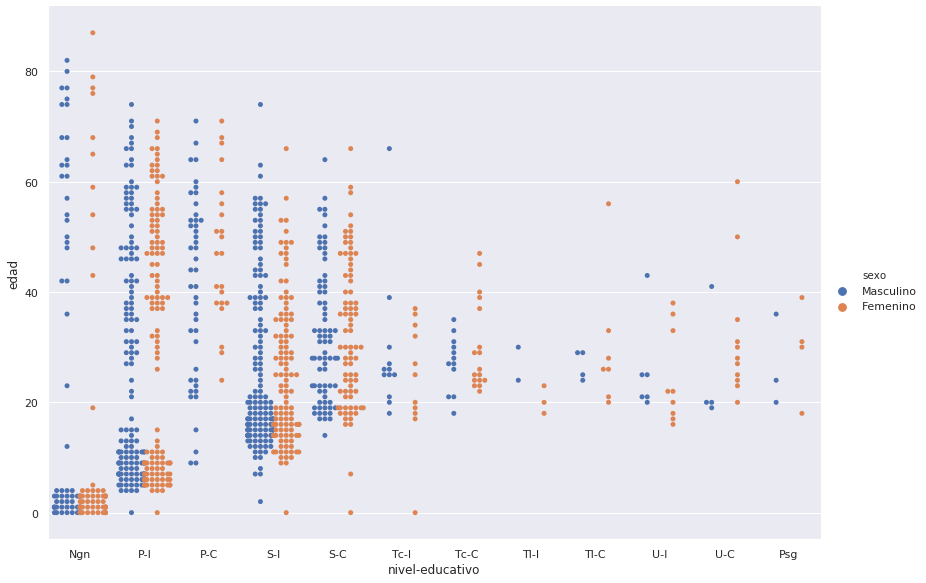

In [151]:
# Read data
#df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/email_campaign_funnel.csv")

'''
Población de referencia OMS | Grupo de Edad
8860|De 0 a 4 años
8690|De 5 a 9 años
8600|De 10 a 14 años
8470|De 15 a 19 años
8220|De 20 a 24 años
7930|De 25 a 29 años
7610|De 30 a 34 años
7150|De 35 a 39 años
6590|De 40 a 44 años
6040|De 45 a 49 años
5370|De 50 a 54 años
4550|De 55 a 59 años
3720|De 60 a 64 años
2960|De 65 a 69 años
2210|De 70 a 74 años
1520|De 75 a 79 años
1510|De 80 y más años
'''


sns.catplot(x='nivel-educativo', y='edad', hue='sexo', order=['ninguno', 'primaria-incompleta', 'primaria-completa',
       'secundaria-incompleta', 'secundaria-completa', 'tecnico-incompleto', 'tecnico-completo', 'tecnologo-incompleto', 
       'tecnologo-completo', 'universitario-incompleto','universitario-completo', 'postgrado'],
        kind="swarm", dodge=True, data=df_personas, height=8.27, aspect=11.7/8.27).set_xticklabels(['Ngn', 'P-I',
                                                            'P-C', 'S-I','S-C','Tc-I', 'Tc-C', 'Tl-I', 'Tl-C','U-I',
                                                             'U-C', 'Psg'])


In [63]:
ocupacion = df_personas['ocupacion'].str.split(' ', expand=True).stack().value_counts()
#ocupacion = df_personas['ocupacion'].str.split(' ', expand=True)
ocupacion

estudiante                  262
serviciosturisticos         244
ama-o-decasa                146
otra                        143
sinoficiouocupacion          82
celador                      66
laboresdelhogar              61
pesca                        53
oficiosdomesticos            28
comercio                     27
construccion                 26
actividadesagropecuarias      2
cuidadodepersonas             1
dtype: int64

In [8]:
saberes-ancentrales = df_personas['saberes-ancentrales'].str.split(' ', expand=True).stack().value_counts()
saberes-ancentrales

SyntaxError: can't assign to operator (<ipython-input-8-75897b69367f>, line 1)

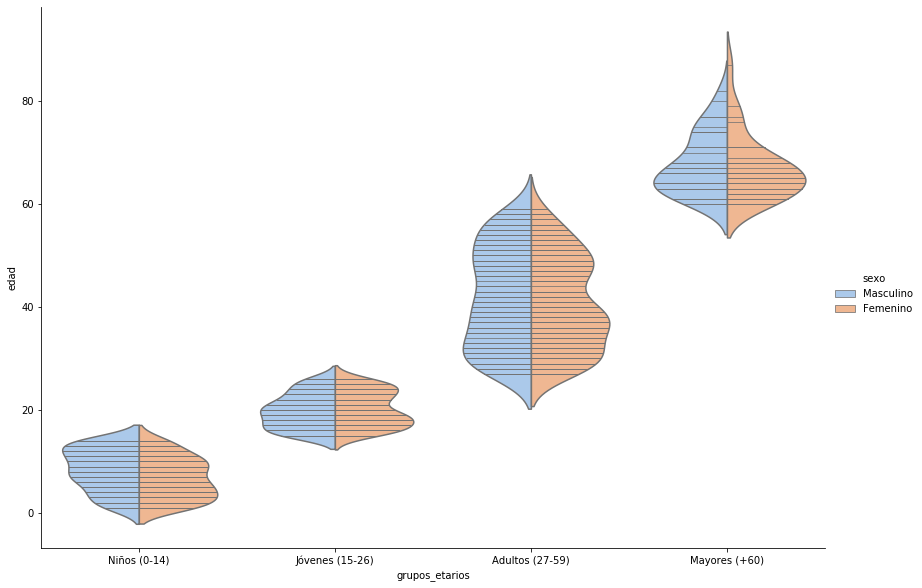

In [62]:
sns.catplot(x="grupos_etarios", y="edad", hue="sexo",
            kind="violin", split=True, data=df_personas, 
            height=8.27, aspect=11.7/8.27, inner="stick", palette='pastel');

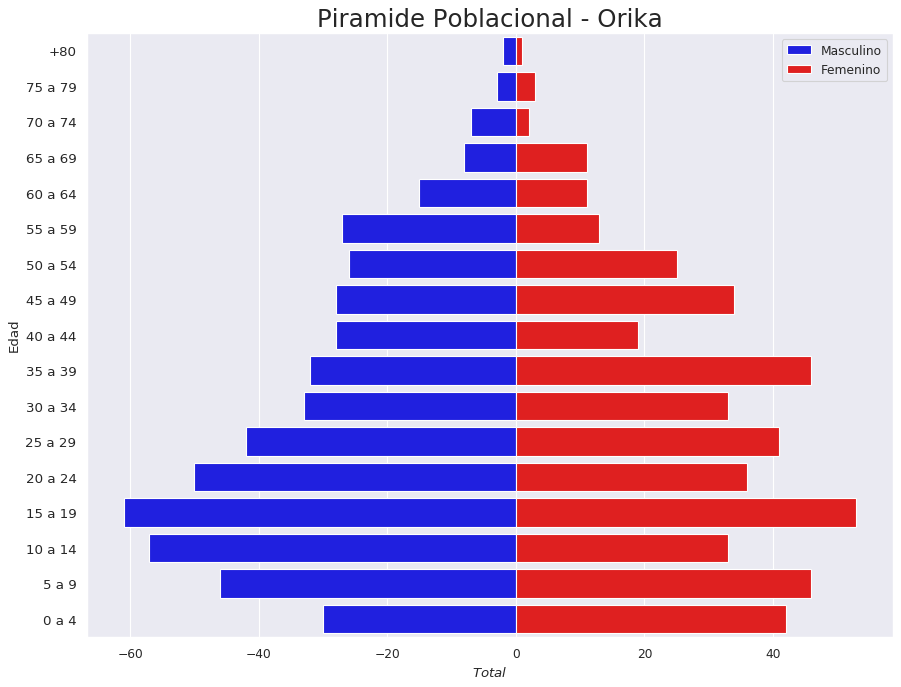

In [148]:
'''
Población de referencia OMS | Grupo de Edad
8860|De 0 a 4 años
8690|De 5 a 9 años
8600|De 10 a 14 años
8470|De 15 a 19 años
8220|De 20 a 24 años
7930|De 25 a 29 años
7610|De 30 a 34 años
7150|De 35 a 39 años
6590|De 40 a 44 años
6040|De 45 a 49 años
5370|De 50 a 54 años
4550|De 55 a 59 años
3720|De 60 a 64 años
2960|De 65 a 69 años
2210|De 70 a 74 años
1520|De 75 a 79 años
1510|De 80 y más años
'''
# Adicionar columna de segmentos de población OMS
df_personas['poblacion_oms'] = pd.cut(df_personas.edad, bins=[0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54,
                                                               59, 64, 69, 74, 79, 100],
                                labels=['0 a 4',
                                        '5 a 9',
                                        '10 a 14',
                                        '15 a 19',
                                        '20 a 24',
                                        '25 a 29',
                                        '30 a 34',
                                        '35 a 39',
                                        '40 a 44',
                                        '45 a 49',
                                        '50 a 54',
                                        '55 a 59',
                                        '60 a 64',
                                        '65 a 69',
                                        '70 a 74',
                                        '75 a 79',
                                        '+80'
                                       ])
# Create dataset
grupo_m = df_personas[df_personas['sexo']=='Masculino'].groupby(['poblacion_oms'])['poblacion_oms'].count().to_frame()
grupo_m['sexo'] = ['Masculino'] * len(grupo_m)
grupo_f = df_personas[df_personas['sexo']=='Femenino'].groupby(['poblacion_oms'])['poblacion_oms'].count().to_frame()
grupo_f['sexo'] = ['Femenino'] * len(grupo_f)
piramide = pd.concat([grupo_m, grupo_f])
piramide.loc[piramide.sexo != 'Femenino', 'poblacion_oms'] *= -1
piramide['grupos'] = piramide.index
piramide.columns = ['total', 'sexo', 'grupo']
piramide.reset_index(drop=True, inplace=True)
piramide


# Read data
df = piramide

# Draw Plot
plt.figure(figsize=(13,10), dpi= 80)
group_col = 'sexo'
order_of_bars = df.grupo.unique()[::-1]
colors = [plt.cm.bwr(i/float(len(df[group_col].unique())-1)) for i in range(len(df[group_col].unique()))]

for c, group in zip(colors, df[group_col].unique()):
    sns.barplot(x='total', y='grupo', data=df.loc[df[group_col]==group, :], order=order_of_bars, color=c, label=group)

# Decorations    
plt.xlabel("$Total$")
plt.ylabel("Edad")
plt.yticks(fontsize=12)
plt.title("Piramide Poblacional - Orika", fontsize=22)
plt.legend()
plt.show()

In [15]:
df_personas.groupby(['autoidentificacion'])['autoidentificacion'].count()

autoidentificacion
afrocolombiano-a-    560
blanco-a-             12
mestizo-a-            37
moreno-a-             76
negro-a-             280
otra                   1
Name: autoidentificacion, dtype: int64

In [17]:
df_personas.groupby(['ocupacion'])['ocupacion'].count()

ocupacion
actividadesagropecuarias                                                        1
actividadesagropecuarias otra                                                   1
ama-o-decasa                                                                   62
ama-o-decasa celador                                                            2
ama-o-decasa comercio                                                           2
ama-o-decasa comercio serviciosturisticos                                       1
ama-o-decasa laboresdelhogar                                                   15
ama-o-decasa otra                                                              14
ama-o-decasa serviciosturisticos                                                2
celador                                                                        49
celador ama-o-decasa                                                            2
celador construccion                                                            1
celado

In [18]:
df_personas.groupby(['saberes-ancentrales'])['saberes-ancentrales'].count()

saberes-ancentrales
Cocina-tradicional                                                            81
Cocina-tradicional baile                                                       3
Cocina-tradicional musica baile gallero siembra pesca                          1
Cocina-tradicional otro                                                        3
Cocina-tradicional pesca                                                       5
Cocina-tradicional pesca baile                                                 1
Cocina-tradicional pesca siembra                                               1
Cocina-tradicional siembra                                                     4
Medicina-tradicional                                                           5
Medicina-tradicional Cocina-tradicional                                        2
Medicina-tradicional otro                                                      1
baile                                                                         51
baile Co

In [16]:
df_personas.groupby(['nivel-educativo'])['nivel-educativo'].count()

nivel-educativo
ninguno                     118
postgrado                     7
primaria-completa            66
primaria-incompleta         262
secundaria-completa         152
secundaria-incompleta       263
tecnico-completo             29
tecnico-incompleto           23
tecnologo-completo           11
tecnologo-incompleto          5
universitario-completo       15
universitario-incompleto     15
Name: nivel-educativo, dtype: int64

In [11]:
orika = pd.read_csv('censo-orika - results.csv')
orika['censo-orika-name'] = orika['censo-orika-numero_edificacion']
coordenadas = orika['censo-orika-coordenadas'].str.split(pat=',', expand=True)
orika['latitud'] = coordenadas[0]
orika['longitud'] = coordenadas[1]
orika['wkt'] = list(zip(pd.to_numeric(orika['longitud']), pd.to_numeric(orika['latitud'])))
orika['wkt'] = orika['wkt'].apply(Point)
orika['edad_construccion'] = (pd.to_datetime(pd.Series([pd.to_datetime('today').date()] * len(orika['censo-orika-fecha_construccion']))) - pd.to_datetime(orika['censo-orika-fecha_construccion'])) / np.timedelta64(1, 'Y')
orika['edad_construccion'] = orika['edad_construccion'].astype(int)
orika['tiempo_habitar'] = (pd.to_datetime(pd.Series([pd.to_datetime('today').date()] * len(orika['censo-orika-fecha_habitar']))) - pd.to_datetime(orika['censo-orika-fecha_habitar'])) / np.timedelta64(1, 'Y')
orika['tiempo_habitar'] = orika['tiempo_habitar'].astype(int)
orika.to_csv('orika.csv',
header=['fecha','inicio','final','deviceid','numero_edificacion','coordenadas','coordenadas-altitude',
'coordenadas-accuracy','tipo_edificacion','tipo_edificacion_otra','responsable_hogar',
'procedencia','procedencia_otra','habitantes','fecha_construccion','fecha_habitar','name','description','firma','nota',
'instanceID','instanceName','latitud','longitud','wkt', 'edad_construccion','tiempo_habitar'], index=False)
# Convertirlo Excel
# Si hay un tipo 'other' adicionarlo en el campo 'description'

In [13]:
censo = pd.read_csv('orika.csv',
                    parse_dates=['fecha_construccion','fecha_habitar'],
                   usecols=[4,8,9,10,11,12,13,14,15,22,23,24,25,26])
censo.columns

Index(['numero_edificacion', 'tipo_edificacion', 'tipo_edificacion_otra',
       'responsable_hogar', 'procedencia', 'procedencia_otra', 'habitantes',
       'fecha_construccion', 'fecha_habitar', 'latitud', 'longitud', 'wkt',
       'edad_construccion', 'tiempo_habitar'],
      dtype='object')

In [14]:
poblacion_viviendas = censo['habitantes'][censo['tipo_edificacion'] != 'lote'].sum()
print('población en viviendas = ' + str(poblacion_viviendas))
print('densidad de población = ' + str(poblacion_viviendas/len(censo[censo['tipo_edificacion'] != 'lote'])))

población en viviendas = 488
densidad de población = 3.189542483660131


In [15]:
censo.groupby(['tipo_edificacion'])['tipo_edificacion'].count()

tipo_edificacion
cantina          5
colegio          1
gallera          1
hotel            1
lote            85
other           15
restaurante      2
tienda           4
vivienda       124
Name: tipo_edificacion, dtype: int64

In [16]:
censo['edad_construccion'].mean()

7.19327731092437

In [17]:
censo.groupby(['tipo_edificacion'])['edad_construccion'].mean()

tipo_edificacion
cantina         7.000000
colegio        42.000000
gallera         3.000000
hotel           9.000000
lote            0.705882
other          10.800000
restaurante     4.500000
tienda          8.750000
vivienda       10.943548
Name: edad_construccion, dtype: float64

In [18]:
censo.groupby(['tipo_edificacion'])['tipo_edificacion'].count()

tipo_edificacion
cantina          5
colegio          1
gallera          1
hotel            1
lote            85
other           15
restaurante      2
tienda           4
vivienda       124
Name: tipo_edificacion, dtype: int64

In [19]:
censo.groupby(['tipo_edificacion_otra'])['tipo_edificacion_otra'].count()

tipo_edificacion_otra
                                                    223
Bodega                                                1
Eco taller                                            1
Eco-Hotel                                             1
Ecohotel                                              1
Ecotel                                                1
Hogar Comunitario                                     1
Iglesia                                               1
Iglesia Pentecostal Unida de Colombia                 1
Negocio de Artesanías                                 1
Negocio de Variedades                                 1
Puesto de salud                                       1
Unidad comunitaria de Atención MUNDO MARINO ICBF      1
Variedades y ferreteria                               1
Vivero                                                1
Área Pública (Casa Cultural)                          1
Name: tipo_edificacion_otra, dtype: int64

In [20]:
censo[censo['tipo_edificacion'] != 'lote'].groupby(['procedencia'])['procedencia'].count()

procedencia
                   2
baru              54
bocachica          2
clemencia          1
isla grande       68
marialabaja        4
other             17
punta arena        1
san onofre         1
santa ana          1
santa catalina     1
turbaco            1
Name: procedencia, dtype: int64

In [21]:
censo[censo['numero_edificacion'] == 132]

,numero_edificacion,tipo_edificacion,tipo_edificacion_otra,responsable_hogar,procedencia,procedencia_otra,habitantes,fecha_construccion,fecha_habitar,latitud,longitud,wkt,edad_construccion,tiempo_habitar
115,132,vivienda,,Roberto Carlos Gómez,isla grande,,4,2017-01-01,2018-01-01,10.175877,-75.743473,POINT (-75.74347333333334 10.17587666666667),2,1


In [22]:
censo.groupby(['procedencia'])['habitantes'].sum()

procedencia
                    1
baru              162
bocachica           5
clemencia           1
isla grande       232
marialabaja        14
other              63
punta arena         1
san onofre          0
santa ana           0
santa catalina      4
tolu                0
turbaco             5
Name: habitantes, dtype: int64

In [32]:
censo.groupby(['procedencia_otra'])['habitantes'].count()

procedencia_otra
                                  210
Cartagena                           8
Cartagena Corralito de piedras      1
Guajira                             1
Libertad Córdoba                    1
Libertad Sucre                      1
Lorica                              1
Marialabaja                         1
Maríalabaja                         2
Momil Córdoba                       4
No Aplica                           1
No aplica                           1
Puerto Escondido Córdoba            1
San Bernardo del Viento             1
San Marcos Sucre                    2
San Onofre Sucre                    1
Turbaco                             1
Name: habitantes, dtype: int64

In [14]:
censo.groupby(['procedencia'])['tiempo_habitar'].mean()

procedencia
                   0.000000
baru               5.920000
bocachica          5.000000
clemencia         12.000000
isla grande        6.079646
marialabaja       12.000000
other              4.821429
punta arena        4.000000
san onofre         0.000000
santa ana          6.000000
santa catalina     5.000000
tolu               0.000000
turbaco           12.000000
Name: tiempo_habitar, dtype: float64

In [15]:
censo.groupby(['procedencia'])['tiempo_habitar'].min()

procedencia
                   0
baru               0
bocachica          0
clemencia         12
isla grande        0
marialabaja       10
other              0
punta arena        0
san onofre         0
santa ana          6
santa catalina     5
tolu               0
turbaco           12
Name: tiempo_habitar, dtype: int64

In [1]:
censo['geometry'] = censo.apply(lambda z: Point(z.longitud, z.latitud), axis=1)
orikageo = gp.GeoDataFrame(censo)
orikageo.plot(figsize=(8, 8))

NameError: name 'censo' is not defined

In [17]:
orika[(orika['censo-orika-numero_edificacion']>41) & (orika['censo-orika-numero_edificacion']<43)]

,censo-orika-today,censo-orika-start,censo-orika-end,censo-orika-deviceid,censo-orika-numero_edificacion,censo-orika-coordenadas,censo-orika-coordenadas-altitude,censo-orika-coordenadas-accuracy,censo-orika-tipo_edificacion,censo-orika-tipo_edificacion_other,...,censo-orika-description,censo-orika-firma,censo-orika-nota,censo-orika-meta-instanceID,censo-orika-meta-instanceName,latitud,longitud,wkt,edad_construccion,tiempo_habitar
41,06/11/18,06/11/18 16:17,06/11/18 16:21,353443092360663,42,"10.177541666666666,-75.74264166666667",-6.0,7.5,vivienda,,...,**Nro. Edificación: **42 **Tipo de edificación...,https://drive.google.com/open?id=16kaPiur0A698...,No hay habitantes en la casa,uuid:a0222ac6-7ea9-425b-a54e-a83aa58dd1e8,42-Alexandra vallesilla Molina-ca24e28e-9591-4...,10.177541666666666,-75.74264166666667,POINT (-75.74264166666667 10.17754166666667),8,1


### Sector El Mocho
#####  Edificaciones por tipo 

In [18]:
censo[(censo['numero_edificacion'] >= 0) & (censo['numero_edificacion'] <= 132)].groupby(['tipo_edificacion'])['tipo_edificacion'].count()

tipo_edificacion
cantina         5
gallera         1
hotel           1
lote           51
other           2
restaurante     1
tienda          3
vivienda       68
Name: tipo_edificacion, dtype: int64

#### Población

In [19]:
censo[(censo['numero_edificacion'] >= 0) & (censo['numero_edificacion'] <= 132)]['habitantes'].sum()

248

### Sector Yazmin

#### Población

In [20]:
censo[(censo['numero_edificacion'] >= 133) & (censo['numero_edificacion'] <= 206)]['habitantes'].sum()

147

#####  Edificaciones por tipo 

In [21]:
censo[(censo['numero_edificacion'] >= 133) & (censo['numero_edificacion'] <= 206)].groupby(['tipo_edificacion'])['tipo_edificacion'].count()

tipo_edificacion
lote           28
other           7
restaurante     1
vivienda       38
Name: tipo_edificacion, dtype: int64

### Sector Petares

#### Población

In [22]:
censo[(censo['numero_edificacion'] >= 207) & (censo['numero_edificacion'] <= 238)]['habitantes'].sum()

93

#####  Edificaciones por tipo

In [23]:
censo[(censo['numero_edificacion'] >= 207) & (censo['numero_edificacion'] <= 238)].groupby(['tipo_edificacion'])['tipo_edificacion'].count()

tipo_edificacion
colegio      1
lote         6
other        6
tienda       1
vivienda    18
Name: tipo_edificacion, dtype: int64